<a href="https://colab.research.google.com/github/patrickzoechbauer/beyondmcmc/blob/main/LinRegSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Install numpyro as well as RAABBVI 

In [ ]:
!pip install numpyro
!pip install pystan==2.19.1.1
!pip install git+https://github.com/Manushi22/viabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Manushi22/viabel to /tmp/pip-req-build-uy7r_5fl
  Running command git clone -q https://github.com/Manushi22/viabel /tmp/pip-req-build-uy7r_5fl


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
import random
import time
import pickle

import numpyro
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist
#assert numpyro.__version__.startswith("0.9.2")

import jax.numpy as jnp
from jax.random import PRNGKey

from scipy.stats import multivariate_normal
from scipy.stats import genpareto
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

import viabel
from viabel.optimization import FASO, RMSProp, RAABBVI
from viabel.objectives import ExclusiveKL
from viabel.approximations import MFGaussian
from viabel.models import Model
from viabel import bbvi, MFStudentT
from viabel.diagnostics import all_diagnostics 

import arviz

from tqdm.notebook import tqdm, trange
import os, sys

# Section 1: Define functions to train MCMC, ADVI and RAABBVI

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
  
set_seed(42)

In [ ]:
def sample_data(N=10000, D = 100):
  beta = np.random.normal(scale = 2.0, size = (D,))
  x = np.random.normal(size = (N,D-1))
  x = np.c_[ x, np.ones(N) ]  

  sigma = 2
  y = np.matmul(x, beta)
  y = y + np.random.normal(0, sigma, size = y.size)

  cols = ["var"+str(i+1) for i in range(D-1)]
  cols.append("intercept")

  return y, x, beta, sigma, cols

In [ ]:
# Defines probabilistc model for numpyro
def model(X, Y=None):
  N, D = X.shape
  sigma = numpyro.sample('sigma', dist.Gamma(rate = 1.0, concentration = 0.5))
  beta = numpyro.sample('beta', dist.Normal(0.0, 1.0).expand([D]).to_event(1))
  mu_est = jnp.dot(X, beta[:,None]).reshape(-1)

  with numpyro.plate('obs', N):
    numpyro.sample('y', dist.Normal(mu_est, sigma), obs = Y)

In [ ]:
# Functions to run VI using RAAABBVI
def log_density(theta):  
    import autograd.numpy as np
    import autograd.scipy.stats.norm as norm
    import autograd.scipy.stats.gamma as gamma
    beta_q, log_sigma_q = theta[:,0:D], theta[:,D]

    #Priors: 
    beta_q = beta_q.mean(axis = 0).squeeze()
    log_sigma_q = log_sigma_q.mean(axis = 0).squeeze()

    #likelihood 
    mu = np.matmul(X, beta_q)

    mu_density = np.sum(norm.logpdf(y, mu, np.exp(log_sigma_q)))
    beta_density = np.sum(norm.logpdf(beta_q, 0, 1))

    sigma_q = np.exp(log_sigma_q)
    sigma_q_density = np.sum(gamma.logpdf(sigma_q, 0.5))

    return beta_density + mu_density + sigma_q_density

def raabbvi(dimension, n_iters=10000, num_mc_samples=10, log_density=None, 
            learning_rate=0.1, RMS_kwargs={'diagnostics':True}, FASO_kwargs=dict()):
    """Fit a model using black-box variational inference.
    """
    model = Model(log_density)
    approx = MFGaussian(dimension)
    objective = ExclusiveKL(approx, model, num_mc_samples)
    init_var_param = approx.init_param()

    base_opt = RMSProp(learning_rate, **RMS_kwargs)
    #opt = FASO(base_opt, **FASO_kwargs)
    opt = RAABBVI(base_opt, **FASO_kwargs)

    opt_results = opt.optimize(n_iters, objective, init_var_param)
    opt_results['objective'] = objective
    return opt_results, approx

In [ ]:
# Function to run MCMC with NUTS sampler
def run_mcmc(model, num_warmup, num_samples, num_chains, X, Y, summary = False):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(PRNGKey(1), X, Y)
    if summary:
      mcmc.print_summary()
    return mcmc.get_samples()

In [ ]:
# Function to calculate PSIS for numpyro VI approx 
def calcPSIS(vi_guide, vi_params):
  #Step 3: Get samples \theta_s for s = 1,...,S
  S = 10000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  theta = np.c_[samples_vi['beta'].to_py(),
                np.log(samples_vi['sigma'].to_py())]

  #Step 4: Calcualte the importance ratio

  #calc log(p(\theta_s, y))
  #lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)

  lp_target = log_density(theta)
  lp_target += np.log(samples_vi['sigma'].to_py())
  ###log(sigma) is the jacobian term in the joint density using log(sigma) as the transformed parameters.

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2

  #check if vi_cov singular
  det = np.linalg.det(vi_cov)
  if det < 0.00001:
      return 10

  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular = True)
  lp_vi = var.logpdf(theta)

  # calc the ratio
  lp_ratio = lp_target-lp_vi

  # Step 5: 
  #select largest M of lp_ratio
  M = int(np.min([S/5, 3*np.sqrt(S)]))
  log_rs_largest = np.partition(lp_ratio,-M)[-M:]

  _, k = arviz.psislw(log_rs_largest, 0.6)

  return k

In [ ]:
def H2(log_weights, alpha=2.):
  log_weights = np.asarray(log_weights)
  log_rescale = np.max(log_weights)

  rescaled_weights = np.exp(log_weights - log_rescale)**alpha
  mean_rescaled_weight = np.mean(rescaled_weights)
  cubo = np.log(mean_rescaled_weight) / alpha + log_rescale
  log_norm_bound = np.mean(log_weights)
  dalpha = alpha / (alpha - 1) * (cubo - log_norm_bound)
  return dalpha  

def WSBoundExpInt(log_weights, samples, p=1):
  d2 = H2(log_weights)
  epsilon = 1
  integral = np.log(np.mean(np.exp(epsilon*d2**p)))
  Cp = 2*((1/epsilon)*(3/2 + integral))**(1/p)
  bound = Cp*(d2**(1/p)+(d2*0.5)**(1/(2*p)))
  return {'W'+str(p):bound}

In [ ]:
def VIbounds(vi_guide, vi_params, expBound = False):
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  sample_vi_transform = np.c_[np.log(samples_vi['sigma'].to_py()), 
                                      samples_vi['beta'].to_py()]

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)
  lp_target += np.log(samples_vi['sigma'].to_py())

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  var = multivariate_normal(mean=vi_mean, 
                              cov=vi_cov)
  lp_vi = var.logpdf(sample_vi_transform)

  # calc the ratio
  log_weights = lp_target-lp_vi
  samples = sample_vi_transform

  if expBound == True: 
    bounds = WSBoundExpInt(log_weights, samples, p=2)
  else: 
    bounds = all_diagnostics(log_weights, samples = samples)

  return bounds

In [ ]:
def AnalyticalW2Bound(vi_params, vi_guide):
  #Calc C_2
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd
  vi_cov = np.matmul(vi_cov, vi_cov)
  #lambdas = np.linalg.eig(vi_cov)[0]
  epsilon = 0.1
  C = 2*((1/epsilon)*((3/2)+np.log((1-2*epsilon)**(-0.5)).sum()))**0.5

  #Approx. KL-divergence
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  sample_vi_transform = np.c_[np.log(samples_vi['sigma'].to_py()), 
                                      samples_vi['beta'].to_py()]

  #calc log(p(\theta_s, y))
  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)
  lp_target += np.log(samples_vi['sigma'].to_py())

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  var = multivariate_normal(mean=vi_mean, 
                              cov=vi_cov)
  lp_vi = var.logpdf(sample_vi_transform)

  # calc the ratio
  log_weights = lp_target-lp_vi

  d2 = H2(log_weights)
  p=2
  bound = C*(d2**(1/p)+(d2*0.5)**(1/(2*p)))

  return {'W2':bound}

In [ ]:
# Function to run ADVI with mean-field approximation
# Stopping criteria is based on relative improvement of ELBO as in Stan
from arviz.stats.diagnostics import rhat
def run_ADVI(model, guide_family, maxiter, X, Y, stopping = 'ELBO', tol = 10**(-2)):
    if guide_family == "AutoDelta":
        guide = autoguide.AutoDelta(model)
    elif guide_family == "AutoDiagonalNormal":
        guide = autoguide.AutoDiagonalNormal(model)

    optimizer = numpyro.optim.Adam(0.1)
    svi = SVI(model, guide, optimizer, Trace_ELBO())
 
    svi_state = svi.init(PRNGKey(1), X=X, Y=Y)
    losses = []
    loss_old = 1
    W2old = 1

    pbar = tqdm(range(maxiter))

    t0 = time.time()
    for i in pbar:
      svi_state, loss_new = svi.update(svi_state, X=X, Y=Y)
      rel_err = jnp.abs((1-loss_new/loss_old))
        
      loss_old = loss_new
      losses.append(loss_new)
      
      if stopping == 'ELBO':
        if rel_err < tol: 
          print('Stopped after {} iterations with default tol of {}.'.format(i+1, tol))
          break
      if stopping == 'PSIS':
        params = svi.get_params(svi_state)
        k =  calcPSIS(guide, params)
        pbar.set_postfix({'k': k})
        if k < 0.7: 
          print('Stopped after {} iterations because k = {:.2f}.'.format(i+1, k))
          break
      if stopping == 'wasserstein':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        rel_W2 = jnp.abs((1-bounds['W2']/W2old))

        pbar.set_postfix({'RelW2': rel_W2, 'W2':bounds['W2']})
        W2old = bounds['W2']
        #print(rel_W2)
        if rel_W2 < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break        

      if stopping == 'wasserstein_abs':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        pbar.set_postfix({'W2':bounds['W2']})
        if bounds['W2'] < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break   

      if stopping == 'time':
        trun = time.time()-t0
        if trun > tol:
          print('Stopped after {} iterations with time tol of {}.'.format(i+1, tol))
          break

      W = 50
      if stopping == 'rhat':
        params = svi.get_params(svi_state)      
        if i == 0: 
          loc = params['auto_loc']
          dim = loc.shape[0]
        else:
          loc = np.c_[loc, params['auto_loc']]
          #scale = np.c_[scale, params['auto_scale']]
        if i > 2*W:
          rhat_array = []
          for l in range(dim):
            locl = loc[l,:]
            k = i-2*W
            chain = np.stack((locl[k:k+W],locl[k+W:k+2*W]))
            rhat_array.append(rhat(chain))
          
          if np.mean(rhat_array) < 2:
            print('Stopped after {} iterations with rhat of {}.'.format(i+1, tol))
            break


    losses = jnp.stack(losses)
    params = svi.get_params(svi_state)

    return losses, params, guide

In [ ]:
# Plot posterior distriutions against ground truth
def plotResults(loc):
  samples_mcmc = np.c_[posterior_samples['beta'].to_py(), 
                       posterior_samples['sigma'].to_py() ]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['beta'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['sigma'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  samples_raabbvi[:,D] = np.exp(samples_raabbvi[:,D])

  #cols_used = cols.copy()
  #cols_used.append()

  cols_used = [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$']

  fig, ax = plt.subplots(figsize=(4,3))
  labels = []

  v1 = ax.violinplot(
      [samples_mcmc[:, i] for i in range(len(cols_used))]
      )
  c1 = v1['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c1), 'MCMC'))

  v2 = ax.violinplot(
      [samples_vi[:, i] for i in range(len(cols_used))]
      )
  c2 = v2['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c2), 'ADVI'))

  v3 = ax.violinplot(
      [samples_raabbvi[:, i] for i in range(len(cols_used))]
      )
  c3 = v3['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c3), 'RAABBVI'))

  #add ground truth
  ground_truth = np.r_[beta, sigma]
  for i in range(len(cols_used)):
    ax.hlines(y=ground_truth[i], xmin=(i+1)-0.1, xmax=(i+1)+0.1, linewidth=2, color='r')

  ax.set_xticks(np.arange(1, len(cols_used) + 1))
  ax.set_xticklabels(cols_used, fontsize=10)
  ax.legend(*zip(*labels), loc=loc)
  plt.title("Linear regression")

In [ ]:
# Performance on the mean:
def MADstats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.mean(axis = 0)
  MAD_mu = np.abs((samples - groundTruth)).mean(axis = 0)
  MAD_beta_mu = MAD_mu[0:D].mean()
  MAD_sigma_mu = MAD_mu[D]
  return [MAD_beta_mu], [MAD_sigma_mu]   

def varianceStats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.std(axis = 0)
  samplesStd = samples.std(axis = 0)
  MAD_std = np.abs((samplesStd-groundTruth))
  MAD_beta_std = MAD_std[0:D].mean()
  MAD_sigma_std = MAD_std[D]
  return [MAD_beta_std], [MAD_sigma_std]

def getPerformance(D):
  ground_truth = np.r_[beta, sigma]

  samples_mcmc = np.c_[posterior_samples['beta'].to_py(), 
                       posterior_samples['sigma'].to_py() ]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['beta'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['sigma'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  samples_raabbvi[:,D] = np.exp(samples_raabbvi[:,D])

  # Calculate mean performance:

  MAD_advi_beta_mu, MAD_advi_sigma_mu = MADstats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_mu, MAD_raabbvi_sigma_mu = MADstats(samples_raabbvi, samples_mcmc, D)

  result_mu = {('beta', 'advi'): MAD_advi_beta_mu,
            ('sigma', 'advi'): MAD_advi_sigma_mu,
            ('beta', 'raabbvi'): MAD_raabbvi_beta_mu,
            ('sigma', 'raabbvi'): MAD_raabbvi_sigma_mu}

  resDf_mu = pd.DataFrame(result_mu)

  # Calculate std performance:

  MAD_advi_beta_std, MAD_advi_sigma_std = varianceStats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_std, MAD_raabbvi_sigma_std = varianceStats(samples_raabbvi, samples_mcmc, D)

  result_std = {('beta', 'advi'): MAD_advi_beta_std,
              ('sigma', 'advi'): MAD_advi_sigma_std,
              ('beta', 'raabbvi'): MAD_raabbvi_beta_std,
              ('sigma', 'raabbvi'): MAD_raabbvi_sigma_std}

  resDf_std = pd.DataFrame(result_std)

  # Calculate wasserstein distance: 

  W_mu_advi = []
  W_mu_raabbvi = []
  for i in range(D):
    W_mu_advi.append(wasserstein_distance(samples_mcmc[:,i], samples_vi[:,i]))
    W_mu_raabbvi.append(wasserstein_distance(samples_mcmc[:,i], samples_raabbvi[:,i]))

  W_mu_advi = np.array(W_mu_advi).mean()
  W_mu_raabbvi = np.array(W_mu_raabbvi).mean()

  W_sigma_advi = wasserstein_distance(samples_mcmc[:,D], samples_vi[:,D])
  W_sigma_raabbvi = wasserstein_distance(samples_mcmc[:,D], samples_raabbvi[:,D])

  result_W = {('beta', 'advi'): [W_mu_advi],
              ('sigma', 'advi'): [W_sigma_advi],
              ('beta', 'raabbvi'): [W_mu_raabbvi],
              ('sigma', 'raabbvi'): [W_sigma_raabbvi]}

  resDf_W = pd.DataFrame(result_W)

  # Calculate KS-test p-value

  KS_mu_advi = []
  KS_mu_raabbvi = []
  for i in range(D):
    _, p_value_advi = ks_2samp(samples_mcmc[:,i], samples_vi[:,i])

    KS_mu_advi.append(p_value_advi)

    _, p_value_raabbvi = ks_2samp(samples_mcmc[:,i], samples_raabbvi[:,i])

    KS_mu_raabbvi.append(p_value_raabbvi)

  KS_mu_advi = np.amin(np.array(KS_mu_advi))
  KS_mu_raabbvi = np.amin(np.array(KS_mu_raabbvi))

  _, KS_sigma_advi = ks_2samp(samples_mcmc[:,D], samples_vi[:,D])
  _, KS_sigma_raabbvi = ks_2samp(samples_mcmc[:,D], samples_raabbvi[:,D])

  result_KS = {('beta', 'advi'): [KS_mu_advi],
              ('sigma', 'advi'): [KS_sigma_advi],
              ('beta', 'raabbvi'): [KS_mu_raabbvi],
              ('sigma', 'raabbvi'): [KS_sigma_raabbvi]}

  resDf_KS = pd.DataFrame(result_KS)

  return resDf_mu, resDf_std, resDf_W, resDf_KS




# Section 2: Run MCMC, ADVI and RAABBVI on sample data

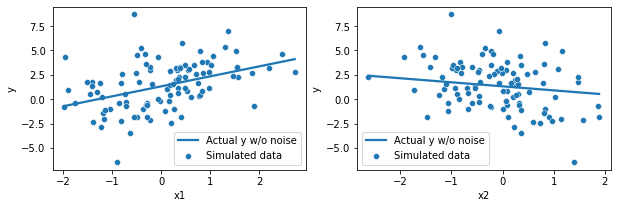

In [ ]:
# Generate data for linear regression
D = 3
N = 100
y, X, beta, sigma, cols = sample_data(N=N, D = D)
y_exact = np.matmul(X, beta)

# Univariate plot of first dimension 
#df = pd.DataFrame({'x':X[:,0], 'y':y, 'y_exact':beta[1]+beta[0]*X[:,0]})
df = pd.DataFrame(np.c_[X, y, y_exact], columns = ['x1', 'x2', 'intercept', 'y', 'y_exact'])
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
sns.scatterplot(data = df, x='x1', y='y', ax = ax[0], 
                label = 'Simulated data')
sns.regplot(data = df, x='x1', y='y_exact', ax = ax[0], ci = None, 
            scatter = False, label = 'Actual y w/o noise')
ax[0].set_ylabel('y', fontsize=10)
ax[0].legend(loc="best")

sns.scatterplot(data = df, x='x2', y='y', ax = ax[1], 
                label = 'Simulated data')
sns.regplot(data = df, x='x2', y='y_exact', ax = ax[1], ci = None, 
            scatter = False, label = 'Actual y w/o noise')
ax[1].set_ylabel('y', fontsize=10)
ax[1].legend(loc="best")
plt.savefig('simulated_data.pdf')  

In [ ]:
# Run MCMC, ADVI and RAABBVI and plot results
import warnings
print('Inference using MCMC:')
posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y, False)
print('---------------------\n')
print('Inference using ADVI:')
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 500, 
                                            X, y, tol = 0.01, 
                                            stopping = 'ELBO')
print('---------------------\n')
print('Inference using RAABBVI:')
results, approx = raabbvi(D+1, log_density=log_density, num_mc_samples=1)

Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:09<00:00, 411.55it/s, 7 steps of size 7.58e-01. acc. prob=0.90]


---------------------

Inference using ADVI:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 5 iterations with default tol of 0.01.
---------------------

Inference using RAABBVI:


average loss = 659.7 | R hat converged|:  17%|█▋        | 1682/10000 [00:03<00:19, 424.39it/s]


Convergence reached at iteration 1682


average loss = 227.95 | R hat converged|:  16%|█▌        | 1336/8317 [00:03<00:16, 415.57it/s]

Convergence reached at iteration 1336



average loss = 227.68 | R hat converged|:  46%|████▌     | 3227/6980 [00:08<00:09, 402.37it/s]


Convergence reached at iteration 3227


Termination rule reached at iteration 6245
Inefficiency Index: 2.3360772932419347


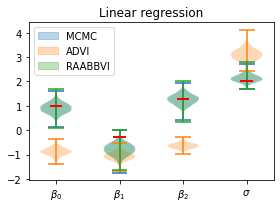

In [ ]:
plotResults('upper left')
plt.tight_layout()
plt.savefig('experiment1_lin.pdf')  

# Section 3: Simulation studies 

## Section 3.1: How well does the stopping criterion, that was proposed in the original ADVI paper work?

In [ ]:
# Run simulation expertiment: 
# Research question: How does standard ADVI compare against RAABBVI?
# This simulation compares the MAD for mean and std for linear regression  
# Note: For std the MCMC estimate is used as the ground truth
resultMu = {('beta', 'advi'): [],
          ('sigma', 'advi'): [],
          ('beta', 'raabbvi'): [],
          ('sigma', 'raabbvi'): []}

resDfMu = pd.DataFrame(resultMu)

resultStd = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfStd = pd.DataFrame(resultStd)


resultW = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfW = pd.DataFrame(resultW)

resultKS = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfKS = pd.DataFrame(resultKS)

N = 1000
D = 100

for i in range(10):
  print('\nIteration: {} of 10'.format(i+1))
  print('-------------------------')
  y, X, beta, sigma, cols = sample_data(N=N, D = D)
  with HiddenPrints():
    posterior_samples = run_mcmc(model, 1000, 1000, 1, X, y)
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 2000, 
                                            X, y, tol = 0.01, 
                                            stopping = 'ELBO')
    results, _ = raabbvi(D+1, log_density=log_density, num_mc_samples=10, n_iters=50000)
  resMu_i, resStd_i, resW_i, resKS_i = getPerformance(D)
  resDfMu = resDfMu.append(resMu_i)
  resDfStd = resDfStd.append(resStd_i)
  resDfW = resDfW.append(resW_i)
  resDfKS = resDfKS.append(resKS_i)

  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 1 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:06<00:00, 288.64it/s, 7 steps of size 4.44e-01. acc. prob=0.82]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,468.2 | R hat converged|:   4%|▎         | 1786/50000 [00:08<03:51, 208.47it/s]
average loss = 2,424.8 | R hat not converged|:   6%|▌         | 2800/48213 [00:14<03:53, 194.63it/s]
average loss = 2,408 | R hat not converged|:   8%|▊         | 3800/45412 [00:18<03:19, 208.62it/s]
average loss = 2,401.3 | R hat converged|:  19%|█▉        | 8054/41611 [00:40<02:48, 199.54it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 2 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:06<00:00, 290.04it/s, 7 steps of size 4.40e-01. acc. prob=0.83]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,500.3 | R hat not converged|:   4%|▍         | 2200/50000 [00:10<03:47, 210.55it/s]
average loss = 2,457.9 | R hat converged|:   6%|▌         | 2687/47799 [00:13<03:45, 200.21it/s]
average loss = 2,441.2 | R hat not converged|:   9%|▉         | 4200/45111 [00:20<03:22, 202.33it/s]
average loss = 2,434.5 | R hat not converged|:  21%|██        | 8400/40910 [00:44<02:51, 189.89it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 3 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:07<00:00, 252.59it/s, 15 steps of size 4.09e-01. acc. prob=0.85]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,433.3 | R hat converged|:   4%|▎         | 1780/50000 [00:08<03:53, 206.77it/s]
average loss = 2,388.2 | R hat not converged|:   5%|▌         | 2600/48219 [00:12<03:37, 209.30it/s]
average loss = 2,370.7 | R hat not converged|:  15%|█▍        | 6800/45618 [00:33<03:13, 200.88it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 4 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:07<00:00, 285.58it/s, 15 steps of size 3.99e-01. acc. prob=0.86]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,452.6 | R hat not converged|:   5%|▍         | 2400/50000 [00:11<03:41, 214.63it/s]
average loss = 2,408.6 | R hat not converged|:   6%|▌         | 2800/47599 [00:13<03:34, 208.52it/s]
average loss = 2,391.7 | R hat not converged|:  12%|█▏        | 5200/44798 [00:25<03:17, 200.04it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 5 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:06<00:00, 286.55it/s, 15 steps of size 3.56e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,478.5 | R hat not converged|:   4%|▍         | 2200/50000 [00:10<03:50, 207.66it/s]
average loss = 2,435.9 | R hat not converged|:   5%|▌         | 2600/47799 [00:13<03:55, 192.08it/s]
average loss = 2,419.4 | R hat not converged|:  12%|█▏        | 5200/45198 [00:25<03:16, 203.58it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 6 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:06<00:00, 286.87it/s, 15 steps of size 3.74e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,457.7 | R hat converged|:   4%|▍         | 1902/50000 [00:09<03:52, 206.90it/s]
average loss = 2,414.3 | R hat not converged|:   5%|▌         | 2600/48097 [00:12<03:35, 211.44it/s]
average loss = 2,397 | R hat not converged|:  11%|█▏        | 5200/45496 [00:26<03:23, 198.19it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 7 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:07<00:00, 265.99it/s, 15 steps of size 3.93e-01. acc. prob=0.87]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,483.6 | R hat not converged|:   3%|▎         | 1600/50000 [00:08<04:02, 199.52it/s]
average loss = 2,440.9 | R hat not converged|:   5%|▍         | 2400/48399 [00:11<03:41, 207.30it/s]
average loss = 2,424.1 | R hat not converged|:  10%|▉         | 4400/45998 [00:21<03:21, 206.51it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 8 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:07<00:00, 275.69it/s, 15 steps of size 3.84e-01. acc. prob=0.88]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,578.1 | R hat not converged|:   5%|▍         | 2400/50000 [00:11<03:52, 204.57it/s]
average loss = 2,535 | R hat not converged|:   5%|▌         | 2600/47599 [00:12<03:34, 209.85it/s]
average loss = 2,518.2 | R hat not converged|:  10%|▉         | 4400/44998 [00:21<03:18, 204.80it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 9 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:07<00:00, 268.64it/s, 15 steps of size 3.97e-01. acc. prob=0.86]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,519.3 | R hat not converged|:   5%|▍         | 2400/50000 [00:11<03:44, 211.58it/s]
average loss = 2,476.6 | R hat not converged|:   5%|▌         | 2600/47599 [00:12<03:38, 205.53it/s]
average loss = 2,459.9 | R hat not converged|:  12%|█▏        | 5400/44998 [00:26<03:14, 204.06it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 10 of 10
-------------------------


sample: 100%|██████████| 2000/2000 [00:06<00:00, 288.66it/s, 15 steps of size 3.58e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 2,517.2 | R hat not converged|:   3%|▎         | 1600/50000 [00:07<03:47, 212.84it/s]
average loss = 2,476.4 | R hat converged|:   5%|▍         | 2256/48399 [00:11<03:45, 204.50it/s]
average loss = 2,460.3 | R hat converged|:  11%|█         | 4899/46142 [00:24<03:23, 202.34it/s]


In [ ]:
#Output for \mu-MAD
df = resDfMu.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_mu_MAD.txt', index = False)

#Output for \sigma-MAD
df = resDfStd.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_sigma_MAD.txt', index = False)

#Output for Wasserstein
df = resDfW.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_W.txt', index = False)

#Output for KS
df = resDfKS.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(5).to_latex('sim1_KS.txt', index = False)

## Section 3.2: Is RAABBVI always better than ADVI or does it only depend on the stopping criteria?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
result = dict()
times = dict()
simTotal = 10
maxLog2T = 8

timesteps = [2**i for i in range(maxLog2T)]

for nsim in range(simTotal):
  print(nsim)

  #Is RAABBVI always better than ADVI? Or does it just depand on the stopping criteria?
  N = 1000
  D = 100
  y, X, beta, sigma, cols = sample_data(N=N, D = D)
  ground_truth = np.r_[beta, sigma]
  k=0

  # Get MCMC perfomance
  posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y)
  samples_mcmc = np.c_[posterior_samples['beta'].to_py(), 
                      posterior_samples['sigma'].to_py()]

  # Get RAABVI performance
  t0_raabbvi = time.time()
  results, _ = raabbvi(D+1, log_density=log_density, num_mc_samples=10, n_iters=50000)
  t_raabbvi = time.time()-t0_raabbvi

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  samples_raabbvi[:,D] = np.exp(samples_raabbvi[:,D])

  # Get ADVI performance for different number of iterations
  for k in timesteps:
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 10000, 
                                                  X, y, stopping = 'time', tol = k)
    
    samplesVI = np.c_[vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['beta'].to_py(),
                      vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['sigma'].to_py()]   
    result[(k, nsim, 'ADVI', 'MAD', 'beta')], result[(k, nsim, 'ADVI', 'MAD', 'sigma')] = \
      MADstats(samplesVI, samples_mcmc, D)

    result[(k, nsim, 'ADVI', 'varErr', 'beta')], result[(k, nsim, 'ADVI', 'varErr', 'sigma')] = \
      varianceStats(samplesVI, samples_mcmc, D)

    result[(k, nsim, 'RAABBVI', 'MAD', 'beta')], result[(k, nsim, 'RAABBVI', 'MAD', 'sigma')] = \
      MADstats(samples_raabbvi, samples_mcmc, D)

    result[(k, nsim, 'RAABBVI', 'varErr', 'beta')], result[(k, nsim, 'RAABBVI', 'varErr', 'sigma')] = \
      varianceStats(samples_raabbvi, samples_mcmc, D)      

    result[(k, nsim, 'RAABBVI', 'time', '')] = t_raabbvi

    result[(k, nsim, 'ADVI', 'time', '')] = k

  #save results
  file_to_write = open("gdrive/My Drive/experiment1_results.pickle", "wb")
  pickle.dump(result, file_to_write)


0


sample: 100%|██████████| 4000/4000 [00:10<00:00, 379.47it/s, 15 steps of size 4.03e-01. acc. prob=0.85]


Using cached StanModel for weighted_lin_regression


average loss = 2,506.7 | R hat not converged|:   5%|▍         | 2400/50000 [00:11<03:47, 209.63it/s]


Convergence reached at iteration 2400


average loss = 2,463.9 | R hat not converged|:   5%|▌         | 2600/47599 [00:13<03:49, 196.10it/s]

Convergence reached at iteration 2600



average loss = 2,447.2 | R hat not converged|:  12%|█▏        | 5400/44998 [00:27<03:22, 195.76it/s]

Convergence reached at iteration 5400


Termination rule reached at iteration 10400
Inefficiency Index: 1.3888849151830263


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 17 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 31 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 60 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 119 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 230 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 461 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 959 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1940 iterations with time tol of 128.
1


sample: 100%|██████████| 4000/4000 [00:09<00:00, 417.97it/s, 7 steps of size 4.12e-01. acc. prob=0.85]


Using cached StanModel for weighted_lin_regression


average loss = 2,527.1 | R hat converged|:   4%|▍         | 1990/50000 [00:09<03:46, 211.97it/s]


Convergence reached at iteration 1990


average loss = 2,486 | R hat not converged|:   5%|▌         | 2600/48009 [00:12<03:31, 214.67it/s]

Convergence reached at iteration 2600



average loss = 2,470.1 | R hat not converged|:   8%|▊         | 3800/45408 [00:17<03:16, 211.91it/s]

Convergence reached at iteration 3800



average loss = 2,463.3 | R hat not converged|:  18%|█▊        | 7600/41607 [00:38<02:51, 198.74it/s]

Convergence reached at iteration 7600


Termination rule reached at iteration 15990
Inefficiency Index: 1.174401036678107


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 37 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 73 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 141 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 276 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 572 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1136 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2195 iterations with time tol of 128.
2


sample: 100%|██████████| 4000/4000 [00:09<00:00, 417.85it/s, 15 steps of size 3.90e-01. acc. prob=0.87]


Using cached StanModel for weighted_lin_regression


average loss = 2,536.1 | R hat not converged|:   5%|▍         | 2400/50000 [00:10<03:33, 223.12it/s]


Convergence reached at iteration 2400


average loss = 2,493.9 | R hat converged|:   6%|▋         | 3076/47599 [00:13<03:22, 220.19it/s]

Convergence reached at iteration 3076



average loss = 2,477.3 | R hat not converged|:  13%|█▎        | 6000/44522 [00:28<03:03, 210.22it/s]

Convergence reached at iteration 6000


Termination rule reached at iteration 11476
Inefficiency Index: 1.282527794713273


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 19 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 38 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 75 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 141 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 298 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 595 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1178 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2251 iterations with time tol of 128.
3


sample: 100%|██████████| 4000/4000 [00:09<00:00, 412.29it/s, 7 steps of size 4.22e-01. acc. prob=0.84]


Using cached StanModel for weighted_lin_regression


average loss = 2,494.8 | R hat converged|:   4%|▎         | 1785/50000 [00:08<03:43, 215.58it/s]


Convergence reached at iteration 1785


average loss = 2,453.1 | R hat converged|:   5%|▍         | 2263/48214 [00:10<03:40, 208.50it/s]

Convergence reached at iteration 2263



average loss = 2,436.7 | R hat converged|:  13%|█▎        | 5985/45950 [00:29<03:15, 204.47it/s]

Convergence reached at iteration 5985


Termination rule reached at iteration 10033
Inefficiency Index: 1.7676352293371258


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 35 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 72 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 145 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 286 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 554 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1162 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2288 iterations with time tol of 128.
4


sample: 100%|██████████| 4000/4000 [00:09<00:00, 407.00it/s, 15 steps of size 3.90e-01. acc. prob=0.87]


Using cached StanModel for weighted_lin_regression


average loss = 2,499.3 | R hat converged|:   4%|▎         | 1779/50000 [00:08<03:45, 214.15it/s]


Convergence reached at iteration 1779


average loss = 2,456 | R hat converged|:   5%|▍         | 2408/48220 [00:11<03:39, 208.36it/s]

Convergence reached at iteration 2408



average loss = 2,438.6 | R hat not converged|:  13%|█▎        | 6000/45811 [00:29<03:13, 205.89it/s]

Convergence reached at iteration 6000


Termination rule reached at iteration 10187
Inefficiency Index: 1.7142095245933076


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 36 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 73 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 144 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 290 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 569 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1147 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2268 iterations with time tol of 128.
5


sample: 100%|██████████| 4000/4000 [00:09<00:00, 404.77it/s, 15 steps of size 3.82e-01. acc. prob=0.88]


Using cached StanModel for weighted_lin_regression


average loss = 2,489 | R hat converged|:   5%|▍         | 2376/50000 [00:11<03:44, 212.51it/s]


Convergence reached at iteration 2376


average loss = 2,446 | R hat not converged|:   5%|▌         | 2600/47623 [00:12<03:35, 208.76it/s]

Convergence reached at iteration 2600



average loss = 2,428.9 | R hat not converged|:  10%|█         | 4600/45022 [00:22<03:18, 203.39it/s]

Convergence reached at iteration 4600


Termination rule reached at iteration 9576
Inefficiency Index: 1.1425501489820995


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 36 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 70 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 142 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 286 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 569 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1142 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2279 iterations with time tol of 128.
6


sample: 100%|██████████| 4000/4000 [00:10<00:00, 395.99it/s, 15 steps of size 3.89e-01. acc. prob=0.87]


Using cached StanModel for weighted_lin_regression


average loss = 2,479.3 | R hat not converged|:   4%|▍         | 2200/50000 [00:10<03:45, 212.22it/s]


Convergence reached at iteration 2200


average loss = 2,435.7 | R hat not converged|:   6%|▌         | 2800/47799 [00:13<03:32, 211.98it/s]

Convergence reached at iteration 2800



average loss = 2,418.7 | R hat not converged|:   9%|▉         | 4000/44998 [00:19<03:22, 202.20it/s]

Convergence reached at iteration 4000



average loss = 2,412 | R hat converged|:  19%|█▊        | 7590/40997 [00:38<02:50, 196.26it/s]

Convergence reached at iteration 7590


Termination rule reached at iteration 16590
Inefficiency Index: 1.1632117037702963


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 36 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 65 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 143 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 289 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 576 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1130 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2248 iterations with time tol of 128.
7


sample: 100%|██████████| 4000/4000 [00:09<00:00, 413.41it/s, 7 steps of size 4.44e-01. acc. prob=0.83]


Using cached StanModel for weighted_lin_regression


average loss = 2,561.5 | R hat not converged|:   3%|▎         | 1600/50000 [00:07<03:43, 216.74it/s]


Convergence reached at iteration 1600


average loss = 2,520.1 | R hat converged|:   6%|▌         | 2703/48399 [00:12<03:37, 210.12it/s]

Convergence reached at iteration 2703



average loss = 2,503.1 | R hat not converged|:  13%|█▎        | 5800/45695 [00:29<03:22, 196.82it/s]

Convergence reached at iteration 5800


Termination rule reached at iteration 10103
Inefficiency Index: 1.4330779029057292


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 34 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 67 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 129 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 284 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 558 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1135 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2307 iterations with time tol of 128.
8


sample: 100%|██████████| 4000/4000 [00:09<00:00, 418.81it/s, 7 steps of size 4.21e-01. acc. prob=0.85] 


Using cached StanModel for weighted_lin_regression


average loss = 2,521.8 | R hat not converged|:   5%|▌         | 2600/50000 [00:11<03:37, 217.81it/s]


Convergence reached at iteration 2600


average loss = 2,477.7 | R hat not converged|:   5%|▌         | 2600/47399 [00:12<03:28, 215.24it/s]

Convergence reached at iteration 2600



average loss = 2,460.6 | R hat converged|:  11%|█         | 4803/44798 [00:23<03:12, 208.06it/s]

Convergence reached at iteration 4803


Termination rule reached at iteration 10003
Inefficiency Index: 1.2186579745827866


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 36 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 72 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 140 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 281 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 564 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1142 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2253 iterations with time tol of 128.
9


sample: 100%|██████████| 4000/4000 [00:09<00:00, 403.90it/s, 7 steps of size 4.39e-01. acc. prob=0.83]


Using cached StanModel for weighted_lin_regression


average loss = 2,520.9 | R hat not converged|:   4%|▍         | 2000/50000 [00:09<03:52, 206.59it/s]


Convergence reached at iteration 2000


average loss = 2,480.1 | R hat not converged|:   6%|▋         | 3000/47999 [00:14<03:43, 201.63it/s]

Convergence reached at iteration 3000



average loss = 2,463.7 | R hat converged|:   9%|▊         | 3840/44998 [00:19<03:25, 200.11it/s]

Convergence reached at iteration 3840



average loss = 2,457.6 | R hat converged|:  21%|██        | 8450/41157 [00:42<02:45, 197.24it/s]

Convergence reached at iteration 8450


Termination rule reached at iteration 17290
Inefficiency Index: 1.1348984247695326


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 18 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 36 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 72 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 142 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 277 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 564 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1119 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2227 iterations with time tol of 128.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


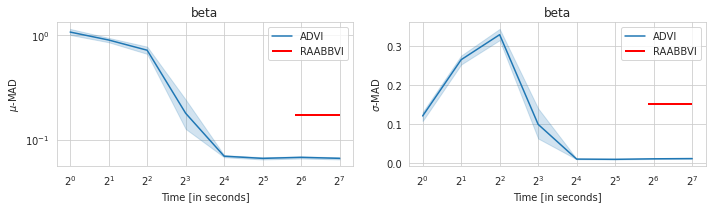

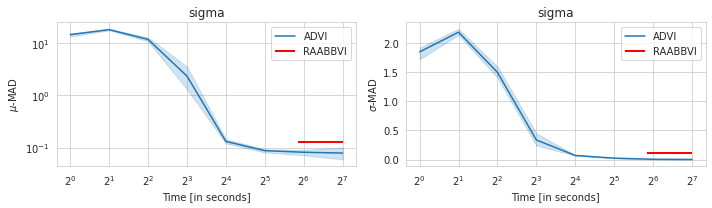

In [ ]:
file_res = open("gdrive/My Drive/experiment1_results.pickle",'rb')
result = pickle.load(file_res)

df = pd.DataFrame(result).stack(level = [0,1])
df.index = df.index.droplevel(level = 0)
df.reset_index(inplace = True)

def plotSimulation1(colname, kpi, df, ax, time = True):
  dfMAD = df.loc[:, (slice(None), kpi, colname)]
  dfMAD.columns = [col[0] for col in dfMAD.columns]
  dfMAD = dfMAD.reset_index()
  dfMAD.drop(columns = ['index'], inplace = True)

  if time: 
    dfMAD['t_advi'] = df.loc[:, ('ADVI', 'time')].values
    dfMAD['t_raabbvi'] = df.loc[:, ('RAABBVI', 'time')].values

    tmin = dfMAD['t_advi'].min()
    tmax = dfMAD['t_advi'].max()

    sns.set_style('whitegrid')
    sns.lineplot(data = dfMAD, x = 't_advi', y = 'ADVI', ax = ax,
                 label = 'ADVI')

    t_RAABBVI = dfMAD['t_raabbvi'].mean()
    val_RAABBVI = dfMAD['RAABBVI'].mean()

    ax.hlines(y=val_RAABBVI, xmin=t_RAABBVI, xmax=dfMAD['t_advi'].max(), 
              linewidth=2, color='r', label = 'RAABBVI')

    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Time [in seconds]')
    ax.legend(loc="best")
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')

  else:
    dfMAD['k'] = 2**df['level_0']

    dfMAD_melted = dfMAD.melt('k', var_name='Method', value_name=kpi)
    sns.set_style('whitegrid')

    sns.lineplot(data = dfMAD_melted, x = 'k', y = kpi, hue = 'Method', 
                      style = 'Method', ax = ax)
    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Number of iterations')
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('beta', 'MAD', df, ax[0])
plotSimulation1('beta', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_beta.pdf')  

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('sigma', 'MAD', df, ax[0])
plotSimulation1('sigma', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_sigma.pdf')  


## Section 3.3: Are there alternative stopping criteria for ADVI that match the performance of RAABBVI?

In [ ]:
# Run simulation with different stopping criteria: 
# 1: Relative improvement in ELBO 
# 2: PSIS k < 0.7 
# 3: Relative improvement in W2 bound 
# 4: RAABBVI 
# 5: MCMC
# Output: 

result = {}
for k in range(5):
  N = 1000
  D = 20
  y, X, beta, sigma, cols = sample_data(N=N, D = D)
  ground_truth = np.r_[beta, sigma]

  import warnings
  print('Inference using MCMC:')
  posterior_samples = run_mcmc(model, 1000, 1000, 1, X, y, False)
  samples_mcmc = np.c_[posterior_samples['beta'].to_py(), 
                      posterior_samples['sigma'].to_py()]

  print('---------------------\n')
  for rule in ['ELBO', 'wasserstein', 'PSIS', 'rhat']:
    print('Inference using ADVI with {}:'.format(rule))
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 1000, 
                                                X, y, tol = 0.01, 
                                                stopping = rule)
      samplesVI = np.c_[vi_guide.sample_posterior(PRNGKey(1), 
                                                  vi_params, 
                                                  (2000,))['beta'].to_py(),
                        vi_guide.sample_posterior(PRNGKey(1), 
                                                  vi_params, 
                                                  (2000,))['sigma'].to_py()]   
      result[(k, 'MAD', 'beta', rule)], result[(k, 'MAD', 'sigma', rule)] = \
        MADstats(samplesVI, samples_mcmc, D)

      result[(k, 'varErr', 'beta', rule)], result[(k, 'varErr', 'sigma', rule)] = \
        varianceStats(samplesVI, samples_mcmc, D)

  print('---------------------\n')
  print('Inference using RAABBVI:')
  results, approx = raabbvi(D+1, log_density=log_density, num_mc_samples=10, n_iters=50000)
  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  samples_raabbvi[:,D] = np.exp(samples_raabbvi[:,D])
  result[(k, 'MAD', 'beta', 'RAABBVI')], result[(k, 'MAD', 'sigma', 'RAABBVI')] = \
    MADstats(samples_raabbvi, samples_mcmc, D)

  result[(k, 'varErr', 'beta', 'RAABBVI')], result[(k, 'varErr', 'sigma', 'RAABBVI')] = \
    varianceStats(samples_raabbvi, samples_mcmc, D)

Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:05<00:00, 356.82it/s, 7 steps of size 6.17e-01. acc. prob=0.87]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 8 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 23 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 77 iterations because k = 0.52.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 102 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 37,597 | R hat not converged|:   2%|▏         | 1200/50000 [00:04<03:18, 245.64it/s]


Convergence reached at iteration 1200


average loss = 2,191 | R hat converged|:   4%|▍         | 1925/48799 [00:07<03:05, 253.33it/s]

Convergence reached at iteration 1925



average loss = 2,187.6 | R hat converged|:   6%|▌         | 2792/46873 [00:11<02:59, 245.27it/s]


Convergence reached at iteration 2792


average loss = 2,186.2 | R hat converged|:  21%|██        | 9074/44080 [00:49<03:09, 185.02it/s]


Convergence reached at iteration 9074


Termination rule reached at iteration 14991
Inefficiency Index: 1.8901445736869769
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:05<00:00, 349.93it/s, 7 steps of size 5.56e-01. acc. prob=0.89]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 8 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 21 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 638 iterations because k = 0.68.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 102 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 2,287.6 | R hat converged|:   3%|▎         | 1369/50000 [00:05<03:21, 241.56it/s]


Convergence reached at iteration 1369


average loss = 2,234.6 | R hat converged|:   4%|▍         | 2149/48630 [00:08<03:11, 242.90it/s]


Convergence reached at iteration 2149


average loss = 2,231.4 | R hat converged|:   7%|▋         | 3025/46480 [00:13<03:14, 223.91it/s]


Convergence reached at iteration 3025


Termination rule reached at iteration 6543
Inefficiency Index: 1.0038032266601025
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:05<00:00, 367.03it/s, 7 steps of size 6.05e-01. acc. prob=0.87]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 2 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 29 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 102 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 42,369 | R hat not converged|:   2%|▏         | 1200/50000 [00:04<03:18, 245.37it/s]


Convergence reached at iteration 1200


average loss = 2,183.8 | R hat converged|:   4%|▍         | 1838/48799 [00:07<03:10, 246.50it/s]

Convergence reached at iteration 1838



average loss = 2,180.4 | R hat converged|:   7%|▋         | 3056/46960 [00:13<03:08, 233.42it/s]

Convergence reached at iteration 3056


Termination rule reached at iteration 6094
Inefficiency Index: 1.1084445241866419
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:05<00:00, 361.48it/s, 7 steps of size 5.91e-01. acc. prob=0.88]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 9 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 26 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 7 iterations because k = 0.59.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 102 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 2,217.9 | R hat not converged|:   3%|▎         | 1400/50000 [00:05<03:15, 248.53it/s]


Convergence reached at iteration 1400


average loss = 2,181.8 | R hat converged|:   4%|▍         | 2180/48599 [00:09<03:14, 238.13it/s]


Convergence reached at iteration 2180


average loss = 2,178.5 | R hat converged|:  12%|█▏        | 5637/46418 [00:24<02:54, 233.35it/s]

Convergence reached at iteration 5637


Termination rule reached at iteration 9217
Inefficiency Index: 2.1552120188649364
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:06<00:00, 320.87it/s, 7 steps of size 5.46e-01. acc. prob=0.89]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 8 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 23 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 92 iterations because k = 0.68.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 112 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 2,244.5 | R hat not converged|:   3%|▎         | 1400/50000 [00:05<03:17, 246.11it/s]


Convergence reached at iteration 1400


average loss = 2,208.2 | R hat converged|:   4%|▍         | 2170/48599 [00:09<03:13, 240.29it/s]


Convergence reached at iteration 2170


average loss = 2,205 | R hat converged|:  12%|█▏        | 5689/46428 [00:25<03:02, 223.57it/s]


Convergence reached at iteration 5689


Termination rule reached at iteration 9259
Inefficiency Index: 2.094867934572547


In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('MAD', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_mu.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

print("-----")
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('varErr', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_sigma.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

col2   ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                         
beta   1.49  0.36     0.17  0.06         0.94
sigma  6.99  1.44     0.12  0.09         8.39
-----
col2   ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                         
beta   0.06  0.02     0.15  0.01         0.16
sigma  1.02  0.23     0.11  0.06         1.32
